## Initial Import of my Library

In [71]:
# Import OS lib
import os
import re

# Prepare for OCR to get information from the initial images
import easyocr

# Prepare for crawling
from googlesearch import search

# Prepare language data
import csv

# Webscraping
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Analysis
import nltk
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.stem import WordNetLemmatizer
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster import hierarchy
import networkx as nx

# Show all matplotlib graphs inline
%matplotlib inline

# Set all graphs to a seaborn style with a grey background grid which makes reading graphs easier
sns.set()

## Collection of Data

In [2]:
languages = {}
development_environment = {}
web_frameworks = {}

with open("languages.csv", "r") as file:
    language_dict = csv.DictReader(file)

    for row in language_dict:
        if row["type"] == "pl":
            key_id = row["pldb_id"]
            languages[key_id] = row

In [3]:
files = [f for f in os.listdir('./images/') 
         if os.path.isfile(os.path.join('./images/', f))]

# Show list of images

In [4]:
def remove_unnesesarry_info(text:str):
        if '%' in text:
            return None
            
        match text:
            case 'Source: surveystackoverflow.co/2024' : return None
            case 'Source: survey stackoverflow.co/2024' : return None
            case text if 'Most' in text: return None
            case text if 'popular' in text : return None
            case text if 'Respondents' in text : return None
            case 'Web frameworks and technologies': return None
            case 'Developer': return None
            case 'Survey' : return None
            case 'Integrated development environment' : return None
            case 'Data licensed under Open Database License (ODbL)' : return None
            case '2024' : return None
                
        return text

In [5]:
temp_list_of_languages = []

def process_languages(text):
    if text is None or'%' in text or len(text.split()) > 1:
        return

    match text:
        case 'JS' : temp_list_of_languages.append('JavaScript')
        case 'C+-': temp_list_of_languages.append('Cpp')
        case 'PY' : temp_list_of_languages.append('Python')
        case 'TS' : temp_list_of_languages.append('TypeScript')
        case 'C#' : temp_list_of_languages.append('CSharp')
        case '2024' : return
        case _ : temp_list_of_languages.append(text)

In [6]:
temp_list_of_web_frameworks = []

def process_web_frameworks(text):
    if text is None or'%' in text:
        return

    match text:
        case 'Node:js' : temp_list_of_web_frameworks.append('Node.js')
        case 'Express' : temp_list_of_web_frameworks.append('Express.js')
        case 'Next js': temp_list_of_web_frameworks.append('Next.js')
        case 'Vuejs': temp_list_of_web_frameworks.append('Vue.js')
        case 'Flask': temp_list_of_web_frameworks.append('Flask python')
        case '2024' : return
        case _ : temp_list_of_web_frameworks.append(text)

In [7]:
temp_list_of_ides = []

def process_ides(text):
    if text is None or'%' in text:
        return

    match text:
        case 'Notepad+ +' : temp_list_of_ides.append('Notepad++')
        case 'Jupyter NotebooklJupyterLab' : temp_list_of_ides.append('JupyterLab')
        case _ : temp_list_of_ides.append(text)

In [8]:
reader = easyocr.Reader(["en"])

files = [f for f in os.listdir('./images/') 
         if os.path.isfile(os.path.join('./images/', f))]

for file in files:
    result = reader.readtext("./images/" + file)
    
    # Fix data given from the image - only extract the programming languages
    for (bbox, text, prob) in result:
        match file:
            case "popular-languages.png": process_languages(remove_unnesesarry_info(text))
            case "popular-web-framework.png": process_web_frameworks(remove_unnesesarry_info(text))
            case "popular-development-environment.png": process_ides(remove_unnesesarry_info(text))

# Clear memory
del reader

KeyboardInterrupt: 

In [ ]:
# Get the top 10 languages - this excludes things like SQL
languages_for_analysis = [lang for lang in temp_list_of_languages if lang.lower() in languages][:10]
web_frameworks_for_analysis = [w_frame for w_frame in temp_list_of_web_frameworks][:10]
ides_for_analysis = [ide for ide in temp_list_of_ides][:10]

print(languages_for_analysis)
print(web_frameworks_for_analysis)
print(ides_for_analysis)

In [ ]:
def scrape_reddit_data(url: str):
    driver = webdriver.Chrome()
    driver.get(url)

    # Wait for comments to load
    try:
        comments = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'div[id="-post-rtjson-content"]')))
    
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        paragraphs = soup.select('div[id="-post-rtjson-content"] p')
    
        texts = [p.get_text(strip=True) for p in paragraphs]

        driver.close()
    
        return texts
    except:
        driver.close()
        return None

In [ ]:
def scrape_hackernews_data(url: str):
    driver = webdriver.Chrome()
    driver.get(url)

    # Wait for comments to load
    try:
        
        comments = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'div.comment div.commtext.c00')))
        
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        paragraphs = soup.select('div.comment div.commtext.c00')     
        
        texts = [p.get_text(strip=True) for p in paragraphs]

        driver.close()
    
        return texts
    except:
        driver.close()
        return None

In [ ]:
# Perform the search
# Reddit
# Hacknews i.e. Hackernews

languages = {}

# Get a wide range of opinions from developers
for lang in languages_for_analysis:
    # # Looking for developer sentiment on the given technology
    query =  "Opinion on " + lang + " :site reddit"
    search_results = search(query, num_results=5)

    for result in search_results:
        data = scrape_reddit_data(result)

        # Skip the data that can't be extracted
        if data is None:
            continue

        if lang not in languages:
            languages[lang] = data
        else:
            languages[lang] += data

    query =  "Opinion on " + lang + " :site hacknews"
    search_results = search(query, num_results=5)

    for result in search_results:
        data = scrape_hackernews_data(result)
        # Skip the data that can't be extracted
        if data is None:
            continue

        if lang not in languages:
            languages[lang] = data
        else:
            languages[lang] += data

In [ ]:
# Get the information for the web frameworks

# Get a wide range of opinions from developers
for w_frame in web_frameworks_for_analysis:
    # # Looking for developer sentiment on the given technology
    query =  "Opinion on " + w_frame + " :site reddit"
    search_results = search(query, num_results=5)

    for result in search_results:
        data = scrape_reddit_data(result)

        # Skip the data that can't be extracted
        if data is None:
            continue

        if lang not in web_frameworks:
            web_frameworks[w_frame] = data
        else:
            web_frameworks[w_frame] += data

    query =  "Opinion on " + w_frame + " :site hacknews"
    search_results = search(query, num_results=5)

    for result in search_results:
        data = scrape_hackernews_data(result)
        # Skip the data that can't be extracted
        if data is None:
            continue

        if lang not in web_frameworks:
            web_frameworks[w_frame] = data
        else:
            web_frameworks[w_frame] += data

In [ ]:
# Get the information for the integrated development environment

# Get a wide range of opinions from developers
for ide in ides_for_analysis:
    # Looking for developer sentiment on the given technology
    query =  "Opinion on " + ide + " :site reddit"
    search_results = search(query, num_results=5)

    for result in search_results:
        data = scrape_reddit_data(result)

        # Skip the data that can't be extracted
        if data is None:
            continue

        if lang not in development_environment:
            development_environment[ide] = data
        else:
            development_environment[ide] += data

    query =  "Opinion on " + ide + " :site hacknews"
    search_results = search(query, num_results=5)

    for result in search_results:
        data = scrape_hackernews_data(result)
        # Skip the data that can't be extracted
        if data is None:
            continue

        if lang not in development_environment:
            development_environment[ide] = data
        else:
            development_environment[ide] += data

In [ ]:
# Get the information for the integrated development environment

# Get a wide range of opinions from developers
for dev in temp_list_of_tools:
    # Looking for developer sentiment on the given technology
    query =  "Opinion on " + dev + " :site reddit"
    search_results = search(query, num_results=5)

    for result in search_results:
        data = scrape_reddit_data(result)

        # Skip the data that can't be extracted
        if data is None:
            continue

        if lang not in tools:
            tools[dev] = data
        else:
            tools[dev] += data

    query =  "Opinion on " + dev + " :site hacknews"
    search_results = search(query, num_results=5)

    for result in search_results:
        data = scrape_hackernews_data(result)
        # Skip the data that can't be extracted
        if data is None:
            continue

        if lang not in tools:
            tools[dev] = data
        else:
            tools[dev] += data

In [ ]:
# Save the text corpus to txt files
# Languages
for key, value in languages.items():
    try:
        with open(f"./languages/{key}.txt", 'w') as file:
            for paragraph in value:
                file.write(paragraph + "\n")
    except:
        print("Failed to save " + key + " file")
        continue

# Development environment
for key, value in development_environment.items():
    try:
        with open(f"./ide/{key}.txt", 'w') as file:
            for paragraph in value:
                file.write(paragraph + "\n")
    except:
        print("Failed to save " + key + " file")
        continue

# Development tools
for key, value in tools.items():
    try:
        with open(f"./tools/{key}.txt", 'w') as file:
            for paragraph in value:
                file.write(paragraph + "\n")
    except:
        print("Failed to save " + key + " file")
        continue

# Web Frameworks
for key, value in web_frameworks.items():
    try:
        with open(f"./web-framework/{key}.txt", 'w') as file:
            for paragraph in value:
                file.write(paragraph + "\n")
    except:
        print("Failed to save " + key + " file")
        continue

## Analysis

In [2]:
language_files = [f for f in os.listdir('./languages/') 
         if os.path.isfile(os.path.join('./languages/', f))]

In [3]:
scraped_data = pd.DataFrame(columns=['Programming_language', 'Comments'])

for idx, file_name in enumerate(language_files):
    file_text = ""
    with open(f"./languages/{file_name}", 'r') as file:
        file_text = file.read()
    
    programming_language = file_name.replace('.txt', '')
    scraped_data.loc[idx] = {
        "Programming_language" : programming_language,
        "Comments" : file_text
    }

scraped_data.describe()

,Programming_language,Comments
count,10,10
unique,10,10
top,Java,but java also is catching up with modern featu...
freq,1,1


In [4]:
scraped_data['comments_length'] = 0

# Looking at collected corpura
for n in range(0, len(scraped_data)):
    msg = """{Programming_language} has a total corpus of {total} words""".format(
        Programming_language = scraped_data["Programming_language"][n],
        total = len(scraped_data["Comments"][n].split(' '))
    )

    scraped_data.loc[n, 'comments_length'] = len(scraped_data["Comments"][n].split(' '))
    
    print(msg)

Java has a total corpus of 66859 words
Rust has a total corpus of 91473 words
JavaScript has a total corpus of 57585 words
PowerShell has a total corpus of 22634 words
Python has a total corpus of 66986 words
Cpp has a total corpus of 102126 words
PHP has a total corpus of 94804 words
TypeScript has a total corpus of 68149 words
Kotlin has a total corpus of 32613 words
CSharp has a total corpus of 42993 words


## Removing Stop Words

In [5]:
nltk.download('stopwords')

def get_freq(corpus):
    corpus = re.sub(r'\.|\>|\,|\"|\"|\"|\—|\–|\-|\?|\!|\:|\;|\(|\)', '', corpus)

    corpus_lst = corpus.lower().split()

    unique_words_full = set(corpus_lst)

    unique_words = [word for word in unique_words_full if not word in stopwords.words('english')]

    word_freqs = pd.DataFrame(columns=['Word', 'Frequency'])

    for idx, word in enumerate(unique_words):
        word_freq_pair = {'Word':word, 'Frequency':corpus_lst.count(word)}
        word_freqs.loc[idx] = word_freq_pair

    return word_freqs

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacquesthurling/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We can use the above function to get the word frequencies of each corpus and assess if we would like to treat any of the most frequent words as stop words

(taken from the example project)

In [6]:
language_frames = []

for n in range(0, len(scraped_data)):
    programming = scraped_data["Programming_language"][n]
    comments = scraped_data["Comments"][n]

    comment_word_freq = get_freq(comments)

    print(f"{programming}: Unique words {comment_word_freq.index.max()+1}")
    language_frames.append(comment_word_freq)

Java: Unique words 7757
Rust: Unique words 9788
JavaScript: Unique words 7418
PowerShell: Unique words 3976
Python: Unique words 7658
Cpp: Unique words 10310
PHP: Unique words 9627
TypeScript: Unique words 7326
Kotlin: Unique words 4527
CSharp: Unique words 5868


As we can see the amount of unique words is quite high for the different programming languages, this would correlate quite nicely, since we are looking at differing opinions from different platforms.

In [7]:
top_words = []

# Get the common top words for all programming languages
for n in range(0, len(language_frames)):
    top_words += list((language_frames[n].sort_values('Frequency', ascending=False).head(300))['Word'])

In [8]:
custom_stopwords = []

I didn't create custom stopwords, since I am interested specifically about the person commenting, I will not remove the first-person singular pronous, as this will have an affect on the sentiment to determine if the person has negative or positive sentiment about the programming language being looked at

### Filter Corpus of Text

In [9]:
nltk.download('punkt')
nltk.download('punkt_tab')

def remove_stopwords(corpus):
    corpus = corpus.lower()
    
    # Remove certain punctuation using regex. This will stop 'said' and 'said.' appearing as different words
    # Do not remove apostrophes
    corpus = re.sub(r'\.|\>|\,|\"|\"|\"|\—|\–|\-|\?|\!|\:|\;|\(|\)', '', corpus)
    
    # Tokenize the corpus - this creates a list of all the words in the corpus 
    tokens = word_tokenize(corpus)
    
    # As well as stopwords, we want to remove tokens with only punctuation, or suffixes separated from words
    punct = ["'", "''", '``', '(', ')', '%', '&', '...', '…', "‘", "’"]
    suffixes = ["'s", "n't", "'ve", "'ll", "'re", "'d"]
    remove_words = punct + suffixes + custom_stopwords + stopwords.words('english')
    
    # Create a new list with stop words removed from the corpus
    filtered_tokens = [word for word in tokens if not word in remove_words]
 
    # Reconstruct corpus as a string
    filtered_corpus = ' '.join(filtered_tokens)
    
    return filtered_corpus

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jacquesthurling/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jacquesthurling/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [10]:
scraped_data['filtered_comments'] = ''

In [11]:
for n in range(0, len(scraped_data)):
    scraped_data.loc[n, 'filtered_comments'] = remove_stopwords(scraped_data["Comments"][n])

# Show that we have the filtered values
scraped_data.describe()

,comments_length
count,10.000000
mean,64622.200000
std,26596.601641
min,22634.000000
25%,46641.000000
50%,66922.500000
75%,85642.000000
max,102126.000000


### Lemmatisation

In [12]:
lemmatizer = WordNetLemmatizer()

def lemmatize_corpus(corpus):
    tokens = word_tokenize(corpus)

    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(lemmatized_tokens)

In [13]:
scraped_data['lemmatized_comments'] = ''

for n in range(0, len(scraped_data)):
    scraped_data.loc[n, 'lemmatized_comments'] = remove_stopwords(scraped_data["Comments"][n])

# Show that we have the lemmatized values
scraped_data.describe()

,comments_length
count,10.000000
mean,64622.200000
std,26596.601641
min,22634.000000
25%,46641.000000
50%,66922.500000
75%,85642.000000
max,102126.000000


### Sentiment Analysis

In [14]:
# Download VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon, a sentiment analysis tool
nltk.download('vader_lexicon')

# Create an instance of the nltk sentiment analyser
analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jacquesthurling/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
scraped_data['neg_sentiment'] = ''
scraped_data['neu_sentiment'] = ''
scraped_data['pos_sentiment'] = ''
scraped_data['comp_sentiment'] = ''

for n in range(0, len(scraped_data)):
    sen_score = analyser.polarity_scores(scraped_data["Comments"][n])
    scraped_data.loc[n, 'neg_sentiment'] = sen_score['neg']
    scraped_data.loc[n, 'neu_sentiment'] = sen_score['neu']
    scraped_data.loc[n, 'pos_sentiment'] = sen_score['pos']
    scraped_data.loc[n, 'comp_sentiment'] = sen_score['compound']

# Show that we have the filtered values
scraped_data.describe()

,comments_length
count,10.000000
mean,64622.200000
std,26596.601641
min,22634.000000
25%,46641.000000
50%,66922.500000
75%,85642.000000
max,102126.000000


### Exploritory Data

Images used when creating wordclouds for the programming languages being discussed:
 - C++ logo
 - C# logo
 - JavaScript logo
 - Kotlin logo
 - Rust logo
 - Powershell logo
 - Python logo
 - TypeScript logo

On the note of using the logo, the logo will be the backdrop of the wordcloud's colour, however the masking isn't being used for this particular instance. If there is a failure, we use the C++ logo for the backdrop for the wordcloud, since the logo is mostly gray, which provides a neutral black wordcloud.

In [16]:
def map_language_name_to_file(name: str):
    match name.lower():
        case "c#" : return f"csharp-logo.png"
        case _ : return f"{name}-logo.png"

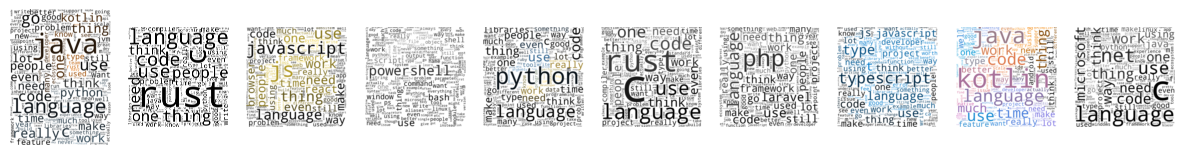

In [17]:
fig, axes = plt.subplots(1,10, figsize=(12, 3))

# # A function to create a wordcloud given a corpus and an image to use a mask
def create_word_cloud(corpus, maskimage, size):
    mask = np.array(Image.open(maskimage))

    word_cloud = WordCloud(background_color="white", mask=mask).generate(corpus)
    return word_cloud

def generate_colour(maskimage):
    mask = np.array(Image.open(maskimage))
    
    return ImageColorGenerator(mask)

# Going over the  
for n in range(0, len(scraped_data)):
    try:
        image_name = map_language_name_to_file(scraped_data["Programming_language"][n].lower())
    
        colours = generate_colour(f'./language-logos/{image_name}')
        
        axes[n].imshow(create_word_cloud(scraped_data["filtered_comments"][n], f'./language-logos/{image_name}', [20,20])
                       .recolor(color_func=colours), 
                       interpolation='bilinear')
        axes[n].axis('off')
    except:
        colours = generate_colour(f'./language-logos/cpp-logo.png')
        
        axes[n].imshow(create_word_cloud(scraped_data["filtered_comments"][n], f'./language-logos/cpp-logo.png', [20,20])
                       .recolor(color_func=colours), 
                       interpolation='bilinear')
        axes[n].axis('off')

plt.tight_layout()

Create wordclouds for all the languages that are being analysed to show the most prominent words used when discussing the programming language

### Word count

In [18]:
pub_palette = sns.blend_palette([
    "#000080",  # Navy Blue
    "#C8A2C8",  # Lilac
    "#FF7F50",  # Coral
    "#006F00",  # Dark Green
    "#FFE900",  # Bright Yellow
    "#E30022",  # Cadmium Red
    "#29AB87",  # Jungle Green
    "#E0B0FF",  # Mauve
    "#8A2BE2",  # Blue Violet
    "#5D2F27"   # Chestnut Brown
], 10)

pub_palette

[(0.0, 0.0, 0.5019607843137255),
 (0.7750865051903114, 0.6278200692041522, 0.7809919261822376),
 (0.9949250288350635, 0.5012687427912341, 0.32479815455593997),
 (0.0, 0.43529411764705883, 0.0),
 (0.9882352941176472, 0.9080968858131488, 0.0),
 (0.8816147635524803, 0.00788927335640094, 0.13799307958477483),
 (0.16078431372549018, 0.6705882352941176, 0.5294117647058824),
 (0.8704959630911185, 0.6779238754325256, 0.9973241061130333),
 (0.5391003460207612, 0.16881199538638986, 0.8776470588235291),
 (0.36470588235294116, 0.1843137254901961, 0.15294117647058825)]

[Text(0.5, 0, '')]

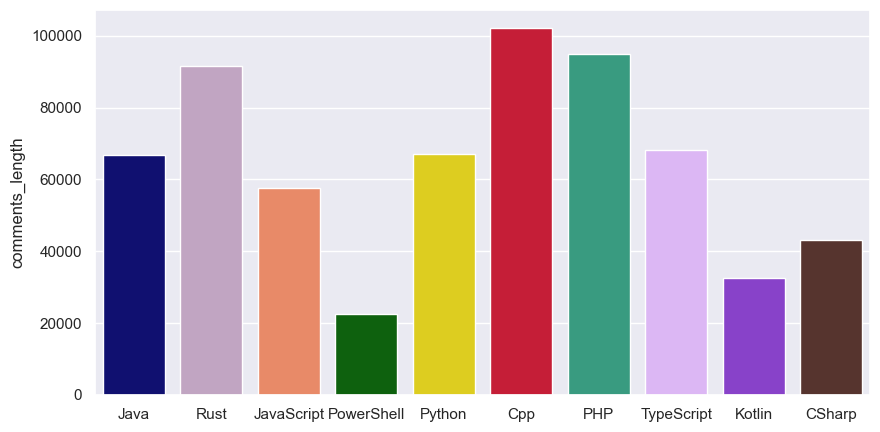

In [19]:
plt.gcf().set_size_inches(10, 5)

ax = sns.barplot(x='Programming_language', y='comments_length', hue='Programming_language', data=scraped_data, palette=pub_palette)

ax.set(xlabel=None)

In [20]:
sentiments = pd.melt(scraped_data, id_vars =['Programming_language'], value_vars=['neg_sentiment','neu_sentiment','pos_sentiment'])

sentiments

,Programming_language,variable,value
0,Java,neg_sentiment,0.076
1,Rust,neg_sentiment,0.08
2,JavaScript,neg_sentiment,0.065
3,PowerShell,neg_sentiment,0.069
4,Python,neg_sentiment,0.064
5,Cpp,neg_sentiment,0.075
6,PHP,neg_sentiment,0.067
7,TypeScript,neg_sentiment,0.071
8,Kotlin,neg_sentiment,0.053
9,CSharp,neg_sentiment,0.059


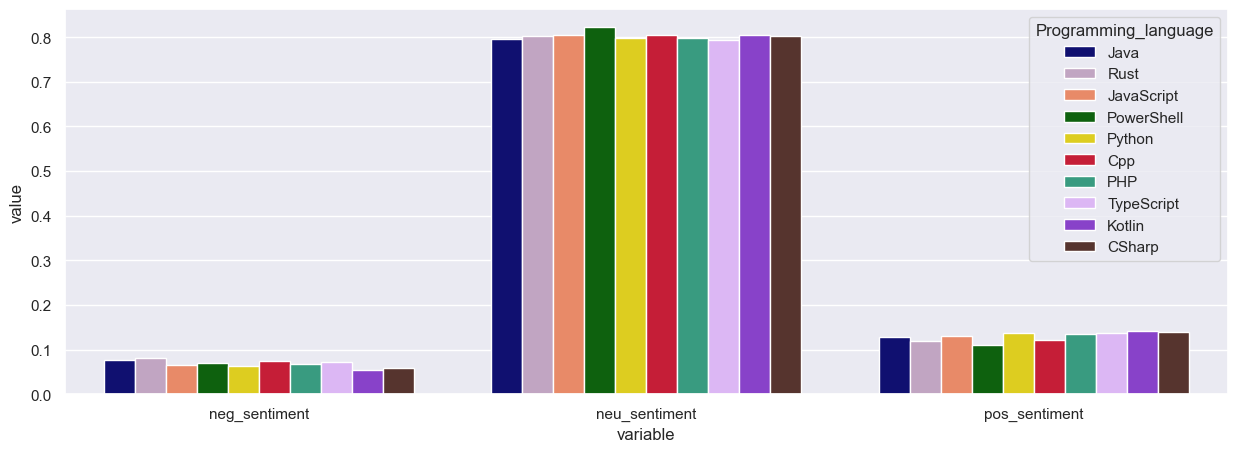

In [21]:
# Create boxplot for negative, neutral and positive sentiment scores

plt.gcf().set_size_inches(15, 5)

ax = sns.barplot(x='variable', y='value', data=sentiments, hue='Programming_language',
                 palette=pub_palette)

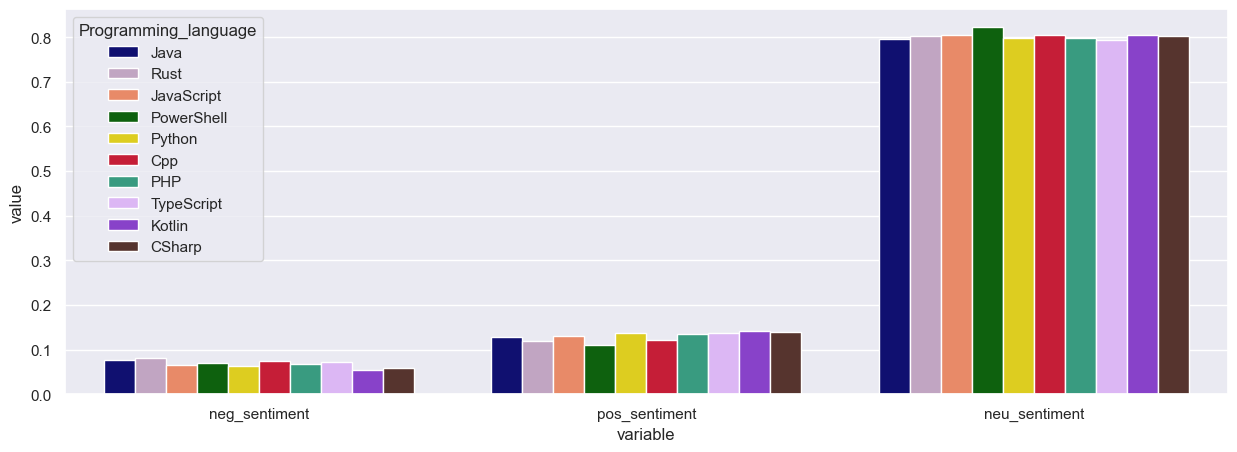

In [22]:
# Sort the sentiment to show what is more represented
plt.gcf().set_size_inches(15, 5)

order = sentiments.groupby('variable')['value'].mean().sort_values().index

# Create the sorted barplot
ax = sns.barplot(
    x='variable', 
    y='value', 
    data=sentiments,
    hue='Programming_language',
    palette=pub_palette,
    order=order
)

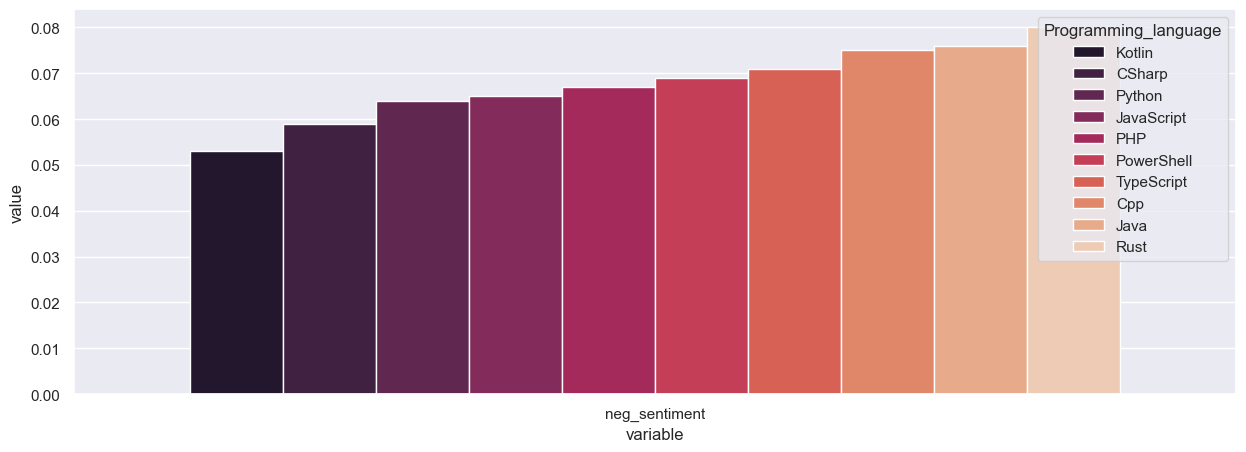

In [23]:
sentiments = pd.melt(scraped_data, id_vars =['Programming_language'], value_vars=['neg_sentiment'])

plt.gcf().set_size_inches(15, 5)

order = sentiments.sort_values('value')

ax = sns.barplot(
    x='variable', 
    y='value', 
    data=order,
    hue='Programming_language',
    palette='rocket',
)

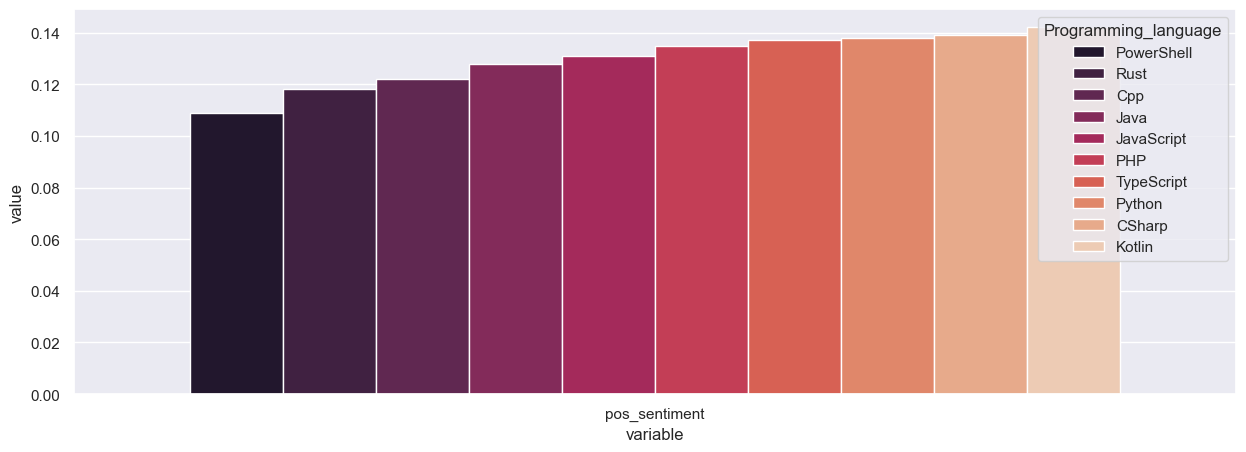

In [24]:
sentiments = pd.melt(scraped_data, id_vars =['Programming_language'], value_vars=['pos_sentiment'])

plt.gcf().set_size_inches(15, 5)

order = sentiments.sort_values('value')

ax = sns.barplot(
    x='variable', 
    y='value', 
    data=order,
    hue='Programming_language',
    palette='rocket',
)

### TF-IDF

In [25]:
tfidf = pd.DataFrame(columns=['Programming_language', 'comment_list'])

for idx, file_name in enumerate(language_files):
    with open(f"./languages/{file_name}", 'r') as file:
        lines = file.readlines()
        # Remove newline characters
        lines = [line.strip() for line in lines]

        programming_language = file_name.replace('.txt', '')
        tfidf.loc[idx] = {
            "Programming_language" : programming_language,
            "comment_list" : [remove_stopwords(line) for line in lines]
        }

len(tfidf['comment_list'][0])

1532

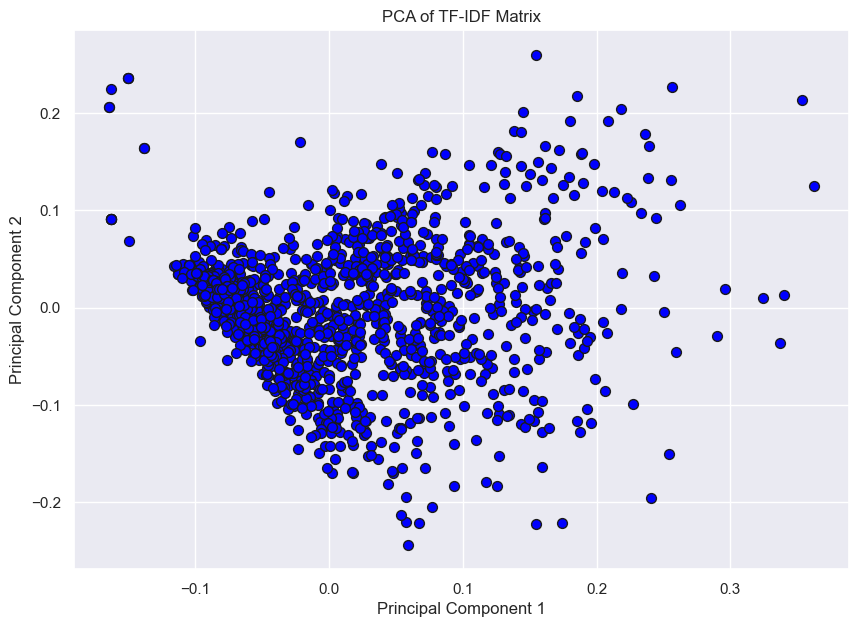

In [26]:
# Create a TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(tfidf['comment_list'][0])

# Using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# Plot results
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', edgecolor='k', s=50)
plt.title('PCA of TF-IDF Matrix')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

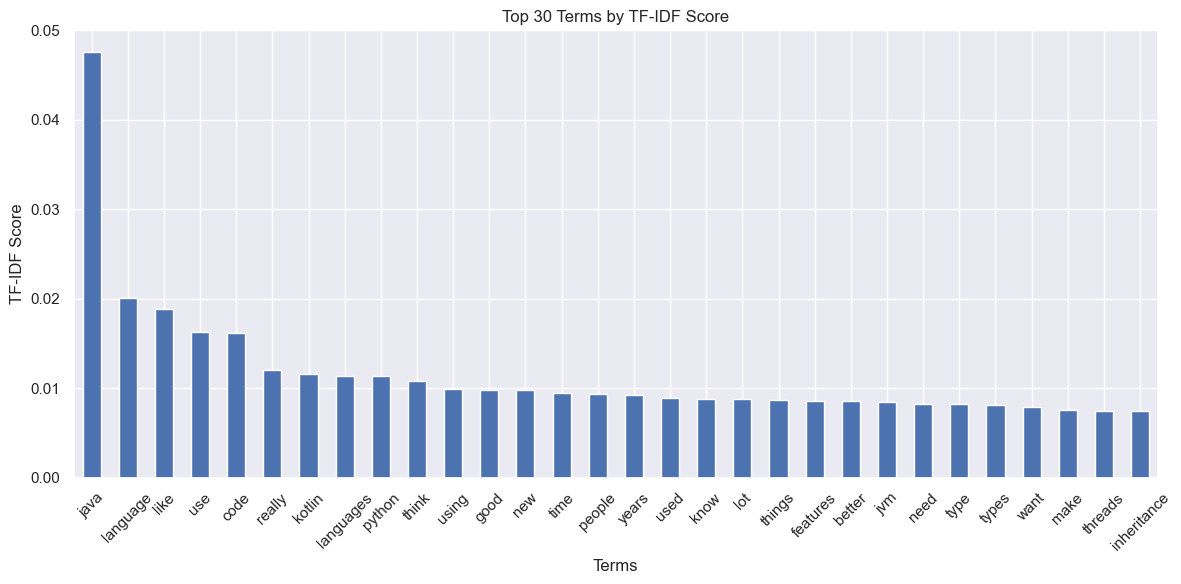

In [45]:
# Convert TF-IDF scores to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), 
                       columns=vectorizer.get_feature_names_out())

# Calculate mean TF-IDF scores
mean_tfidf = tfidf_df.mean().sort_values(ascending=False)

# Plot top terms
plt.figure(figsize=(12, 6))
mean_tfidf.head(30).plot(kind='bar')
plt.title('Top 30 Terms by TF-IDF Score')
plt.xlabel('Terms')
plt.ylabel('TF-IDF Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [75]:
# Calculate similarity matrix
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = vectorizer.fit_transform(tfidf.head(100)['comment_list'][0])
similarity_matrix = cosine_similarity(tfidf_matrix)

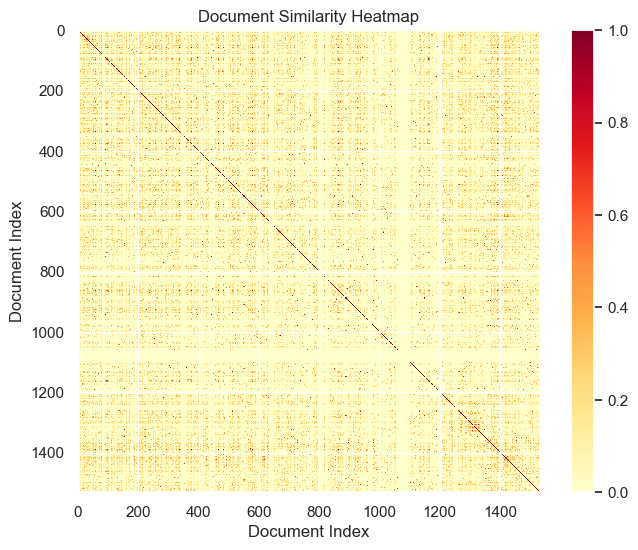

In [78]:
# Create heatmap
plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix, interpolation='nearest', cmap='YlOrRd')
plt.colorbar()
plt.title('Document Similarity Heatmap')
plt.xlabel('Document Index')
plt.ylabel('Document Index')
plt.show()

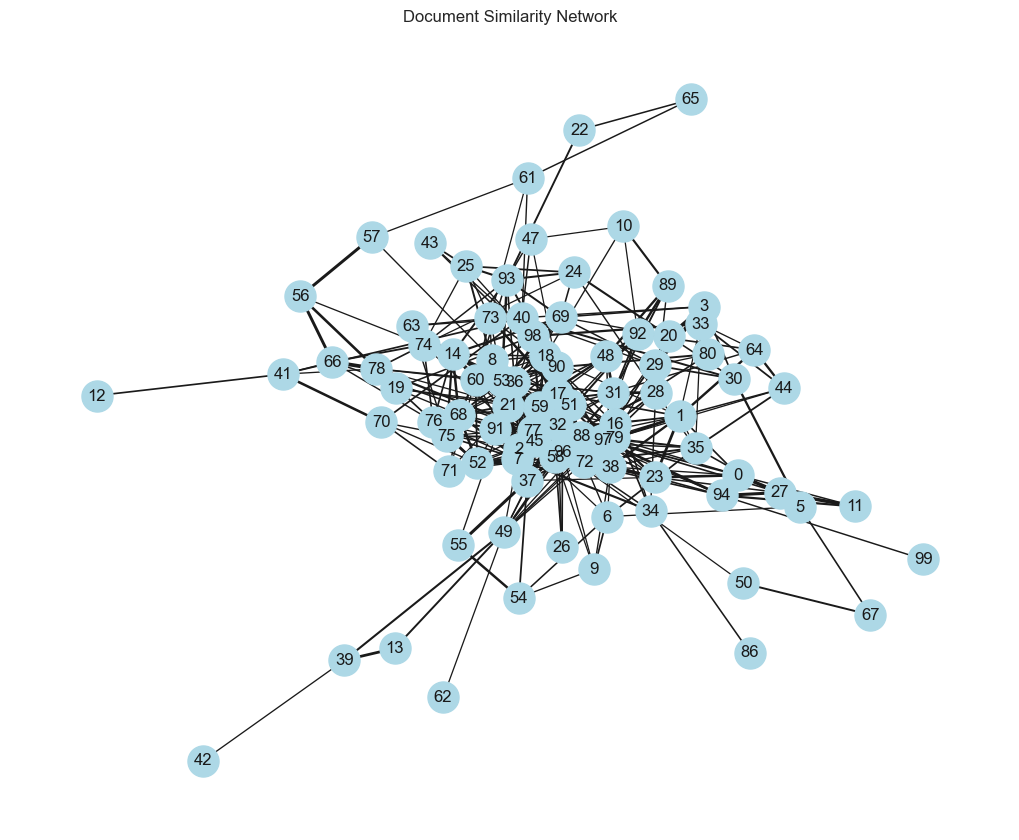

In [77]:
# Create and draw network
plt.figure(figsize=(10, 8))
G = nx.Graph()
for i in range(100):
    for j in range(i+1, 100):
        if similarity_matrix[i][j] > 0.3:
            G.add_edge(i, j, weight=similarity_matrix[i][j])

pos = nx.spring_layout(G)
nx.draw(G, pos, 
        node_color='lightblue',
        node_size=500,
        with_labels=True,
        width=[G[u][v]['weight'] * 3 for u,v in G.edges()])
plt.title('Document Similarity Network')
plt.show()